In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

In [3]:
rng = np.random.default_rng(1234)

def generate():
    group_list = ["one", "two", "three", "four", "five"]
    trials_per_group = 20
    group_intercepts = rng.normal(0, 1, len(group_list))
    group_slopes = np.ones(len(group_list)) * -0.5
    group_mx = group_intercepts * 2
    group = np.repeat(group_list, trials_per_group)
    subject = np.concatenate(
        [np.ones(trials_per_group) * i for i in np.arange(len(group_list))]
    ).astype(int)
    intercept = np.repeat(group_intercepts, trials_per_group)
    slope = np.repeat(group_slopes, trials_per_group)
    mx = np.repeat(group_mx, trials_per_group)
    x = rng.normal(mx, 1)
    y = rng.normal(intercept + (x - mx) * slope, 1)
    data = pd.DataFrame({"group": group, "group_idx": subject, "x": x, "y": y})
    return data, group_list


data, group_list = generate()

In [6]:
coords = {"group": group_list, "observation": np.arange(data.shape[0])}  # actual group names

with pm.Model(coords=coords) as ind_slope_intercept:
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=2, dims="group")
    β0 = pm.Normal("β0", 0, sigma=5, dims="group")
    β1 = pm.Normal("β1", 0, sigma=5, dims="group")
    # Data
    x = pm.Data("x", data.x, dims="observation")
    g = pm.Data("g", data.group_idx, dims="observation")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="observation")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="observation")

In [17]:
β0[4]

Subtensor{int64}.0

In [7]:
with ind_slope_intercept:
    trace = pm.sample(tune=1000, draws=500, cores=4, return_inferencedata=True, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β1, β0, sigma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 15 seconds.


In [8]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β0[one],-2.563,0.572,-3.668,-1.496,0.014,0.010,1592.0,1153.0,1.00
β0[two],0.203,0.250,-0.290,0.651,0.006,0.005,2038.0,1287.0,1.00
β0[three],2.294,0.414,1.488,3.025,0.013,0.009,1093.0,1027.0,1.00
β0[four],-0.030,0.281,-0.575,0.507,0.006,0.006,2230.0,1506.0,1.00
β0[five],1.689,0.723,0.355,2.980,0.022,0.016,1142.0,1051.0,1.01
...,...,...,...,...,...,...,...,...,...
μ[95],0.106,0.533,-0.945,1.031,0.013,0.011,1625.0,1354.0,1.00
μ[96],0.938,0.328,0.302,1.554,0.008,0.006,1521.0,1521.0,1.00
μ[97],0.670,0.303,0.092,1.213,0.007,0.005,2045.0,1297.0,1.00
μ[98],1.630,0.686,0.365,2.866,0.021,0.015,1145.0,1125.0,1.00


/Users/timjdavey/Projects/darkness/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (115) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'β0\none'}>,
        <AxesSubplot:title={'center':'β0\ntwo'}>,
        <AxesSubplot:title={'center':'β0\nthree'}>,
        <AxesSubplot:title={'center':'β0\nfour'}>],
       [<AxesSubplot:title={'center':'β0\nfive'}>,
        <AxesSubplot:title={'center':'β1\none'}>,
        <AxesSubplot:title={'center':'β1\ntwo'}>,
        <AxesSubplot:title={'center':'β1\nthree'}>],
       [<AxesSubplot:title={'center':'β1\nfour'}>,
        <AxesSubplot:title={'center':'β1\nfive'}>,
        <AxesSubplot:title={'center':'sigma\none'}>,
        <AxesSubplot:title={'center':'sigma\ntwo'}>],
       [<AxesSubplot:title={'center':'sigma\nthree'}>,
        <AxesSubplot:title={'center':'sigma\nfour'}>,
        <AxesSubplot:title={'center':'sigma\nfive'}>,
        <AxesSubplot:title={'center':'μ\n0'}>],
       [<AxesSubplot:title={'center':'μ\n1'}>,
        <AxesSubplot:title={'center':'μ\n2'}>,
        <AxesSubplot:title={'center':'μ\n3'}>,
        <AxesSubplot:title={'ce

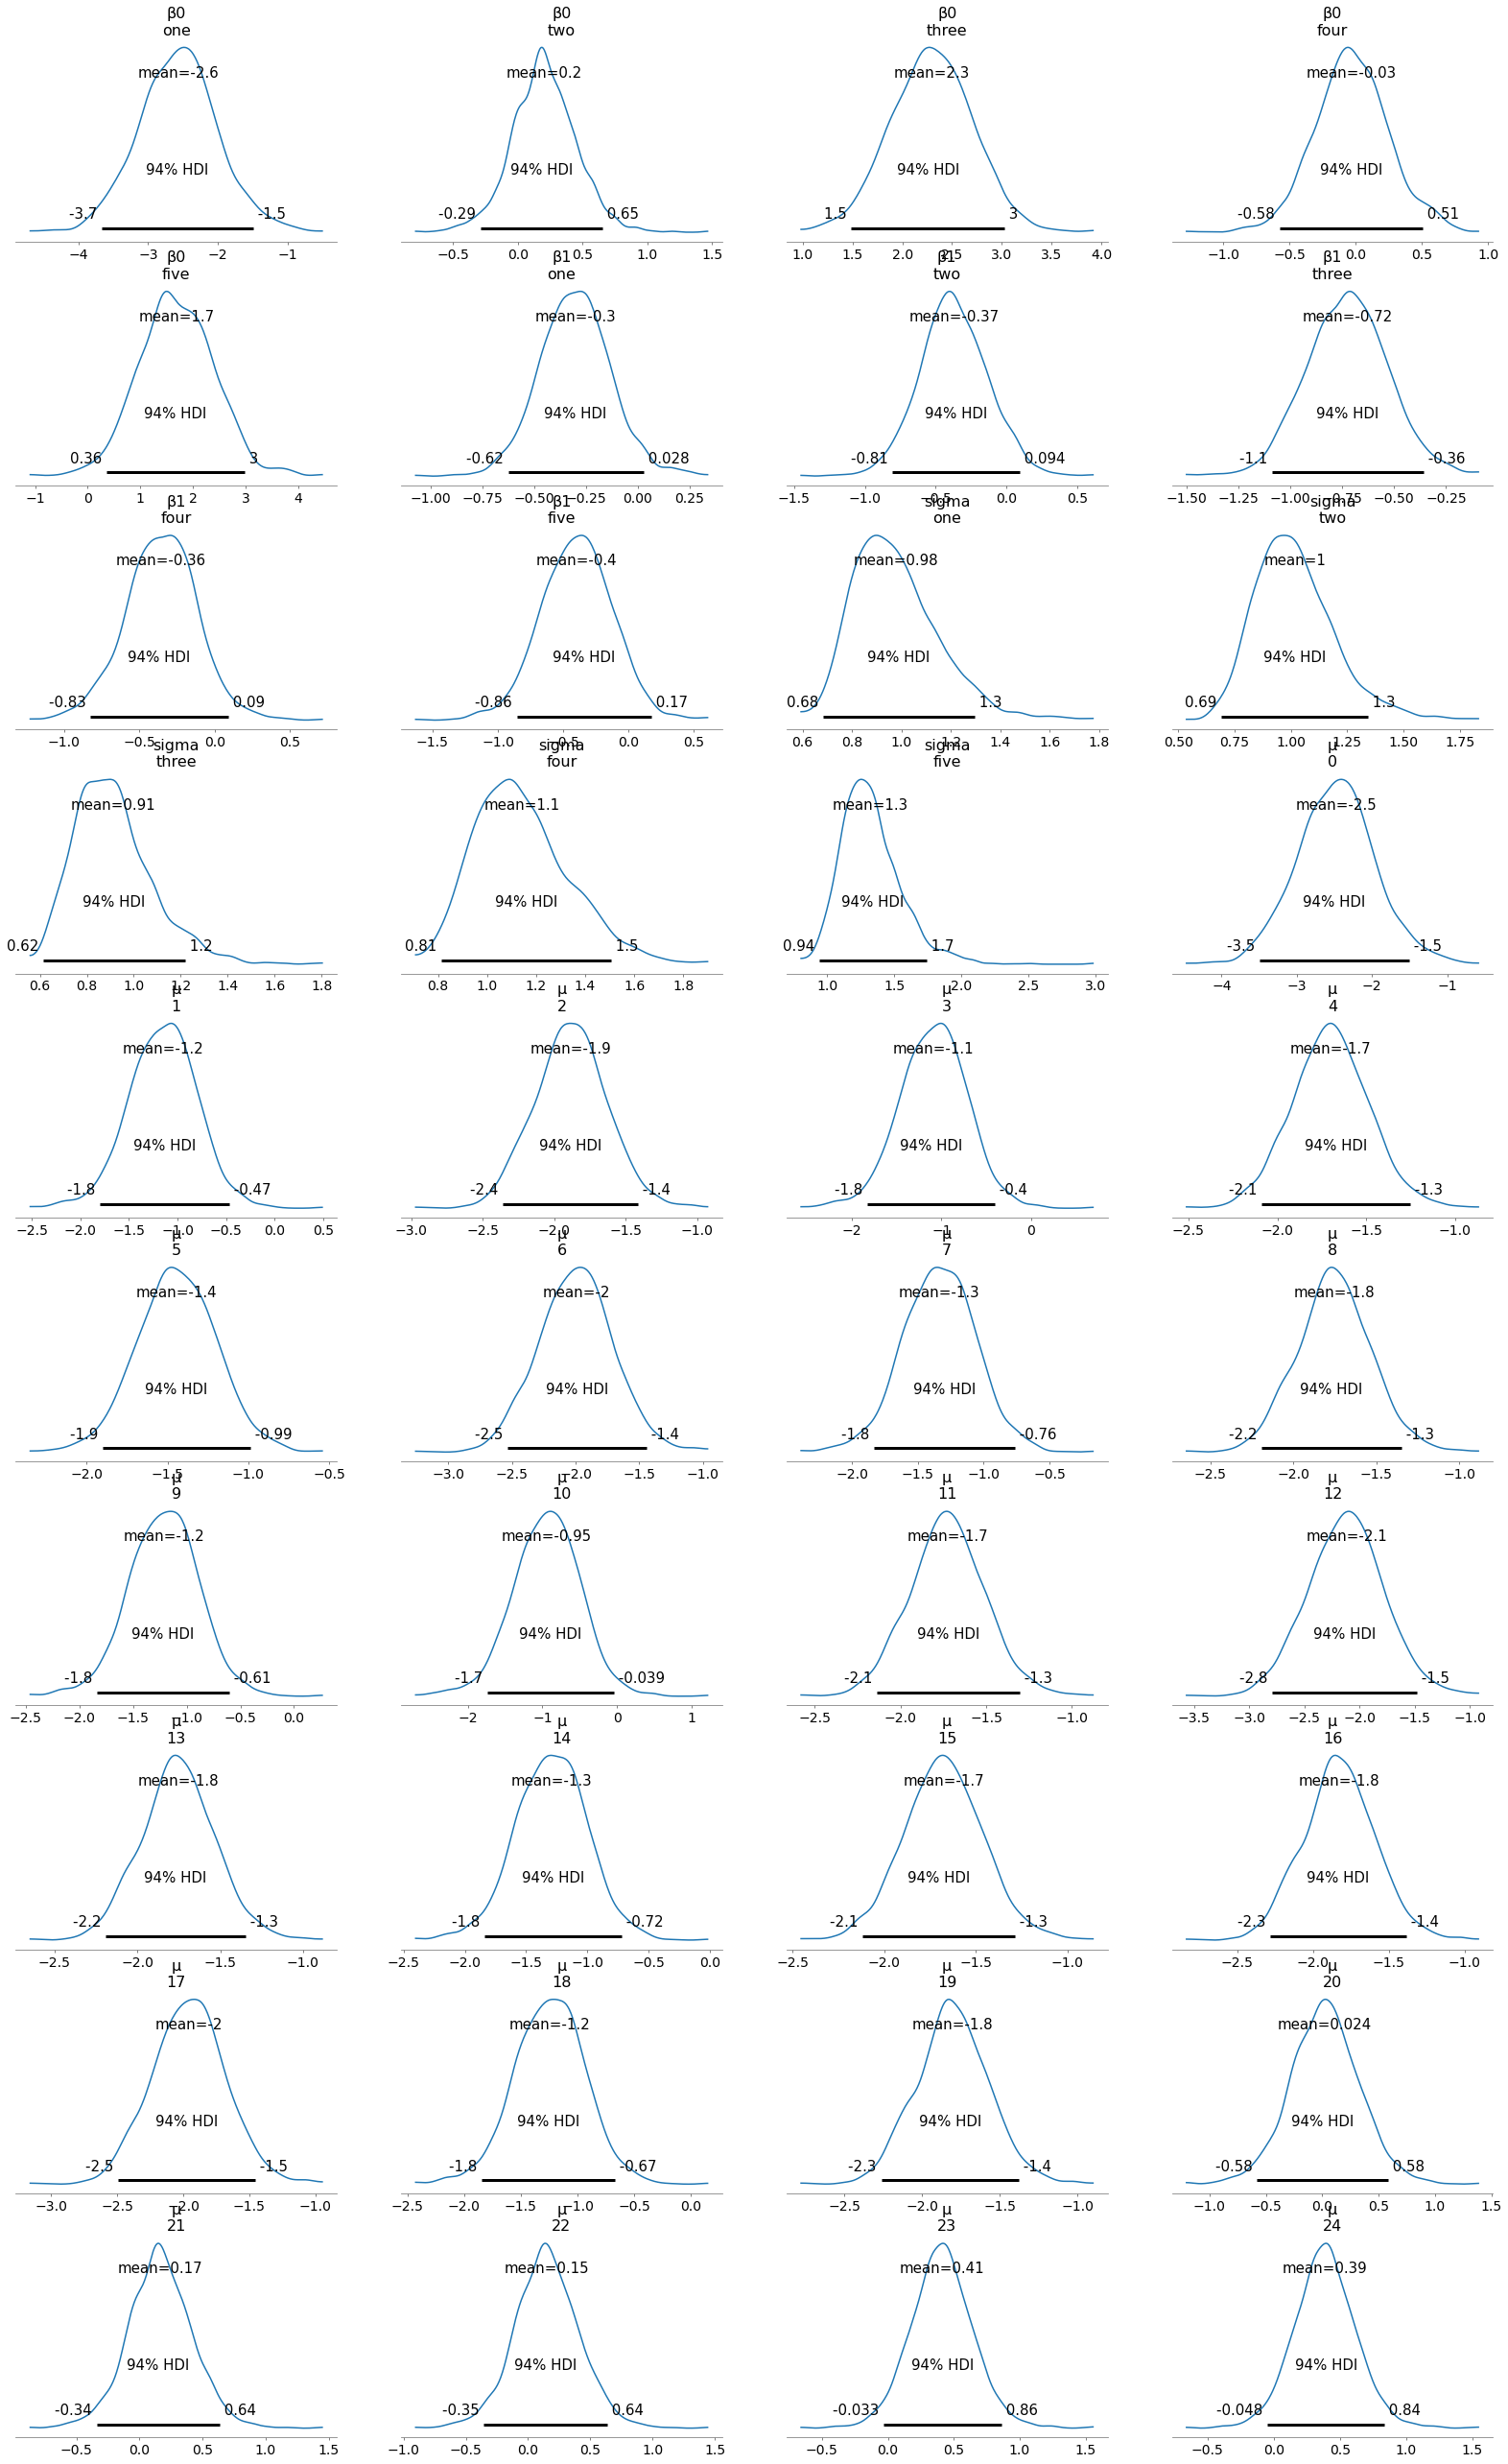

In [9]:
az.plot_posterior(trace)

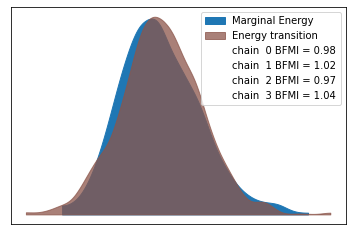

In [10]:
az.plot_energy(trace)
